In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
pd.set_option('display.max_columns', None)

Frame the Problem & Look At the Big Picture 
-------------------------------------------

1. Define the objective in business terms. 
    * The business objective is to predict the stock price for a specific ticker 7 days into the future.
2. How will your solution be used? 
    * The solution will be used to determine when to buy and/or sell stock(s). 
3. What are the current solutions/workarounds (if any)? 
    * There are other people/companies who have attempted to do this with varying levels of success. For many people, they trade stocks using technical analysis which means they intuitively learn trends using various signals (many of which are in the data set).
4. How should you frame this problem?
    * This problem is going to be framed as an offline regression (forecasting) model, but it should ideally be an online model so that it can constantly learn from new data when the stock market is open.
    * If we end up using AWS, then this model will be an online regression model.
    * Also multioutput regression because we are trying to predict for multiple stocks at the same time.
5. How should performance be measured?
    * Root mean squared error (RMSE). 
6. What would be the minimum performance needed to reach the business objective?
    * The minimum performance needed would, at the very least, correctly identify the directional trend of price (up or down), but it would additionally be heavily preferable if the prices/change in prices were as close to the true value as possible (minimum distance).
7. What are comparable problems?
    * We have not worked on any other comparable problems that also used time-series data, but there are AWS resources we can look into as well as read the chapter of the textbook on time-series data. 
8. Is human expertise available?
    * {Jeff, Google, StackOverFlow, GitHub CoPilot}
9. How would you solve this problem manually?
    * Ask WSB (lol… unless?)
    * In reality, I would only use a fraction of the indicators that are already provided in the data set (such as MACD, RSI, EMA, VWAP). These indicators are graphed as lines against the price of the stock prices and can be used to infer whether the stock price will move up or down.
10. List the assumptions you have made so far. Verify the assumptions if possible.
    * I am assuming that the data is historically accurate.
    * The types of trends identified for one company can also be applied to others, otherwise you would probably need a separate model for each company.

Get the Data 
----
1. List the data you need and how much you need 
    * We need historic stock data with lots of technical indicators (around 60 features) and other general indicators. At least a few thousand samples would be nice, but we luckily have over 34,000.
2. Find and document where you can get that data 
    * Our dataset was found on Kaggle Open Source: https://www.kaggle.com/datasets/nikhilkohli/us-stock-market-data-60-extracted-features (Links to an external site.)
3. Get access authorizations 
    * Free to use
4. Create a workspace (with enough storage space) 
    * This notebook / hippocampus
5. Get the data 
    * Done
6. Convert the data to a format you can easily manipulate (without changing the data itself) 
    * Done
7. Ensure sensitive information is deleted or protected (e.g. anonymized) 
    * N/A
8. Check the size and type of data (time series, geographical, ...) 
    * Time Series Data
9. Sample a test set, put it aside, and never look at it (no data snooping!)  

In [9]:
# methods

def load_data():
    """
    Loads the data from the csv files and creates a column for ticker
    """
    data = None
    for root, _, files in os.walk('./data'):
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(root, file))
                # make the date the index
                df.set_index('Date', inplace=True)
                # prefix the columns with the ticker
                ticker = file.split('.')[0]
                df = df.add_prefix(ticker + '_')
                if data is None:
                    data = df
                else:
                    # join on the index
                    data = data.join(df)
    return data
                


In [10]:
data = load_data()

In [18]:
# create a training and test set
# training set with 80% of the data
train = data.iloc[:int(len(data) * 0.8)]
# test set with 20% of the data
test = data.iloc[int(len(data) * 0.8):]

Explore the data
----
1. Copy the data for exploration, downsampling to a manageable size if necessary. 
    * Done
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...) 
    * The only data that was not numeric was the name(ticker) of the stock, and the date, but those were either made part of the index or column names.
    * All remaining attributes are numeric.
    * Some are categorical, all time-related
    * The distributions of many of the attributes change from stock to stock, which is interesting, but also makes sense. It could be worth it to make transformations based on the averages, making the model well rounded, but it would introduce some level of error for each stock than if it was trained individually. 
3. For supervised learning tasks, identify the target attribute(s) 
    * Closing Price for each stock (or percentage change in price of the scaling reduces the ability of the model to predict prices)
4. Visualize the data 
    * Done Below
5. Study the correlations between attributes 
6. Study how you would solve the problem manually 
7. Identify the promising transformations you may want to apply 
    * Features such as *_S_Close(t-N), *_S_Open(t-1), *_QQQ(t-n), SnP(t-n), *_DJIA(t-n) should be dropped because they are historic data included in one sample. If included, would be lots of duplicate data.
    * *_Close_Forecast should also be dropped because it is the tomorrow's target, obviously do not want the y in the X.
    * Drop *_Date_col because the date is already the index.
    * After checking the correlation of the other time data... <b>TODO</b>
    * Some companies, like Tesla, were not public during the beginning of this data set, so the data will have to be imputed
        * We do not wish to drop the samples because we would be missing out on lots of data. Alternatively, those companies could be dropped altogether, but it might be the model less diverse.
    * We predict that a min-max scaler would be more suitable for the data since the stock prices can vary very much between stocks. (ex. AMZN in 1000s and MSFT at ~100)
        * It may be possible that this will result in the model being unable to accurately know the range that the stock falls in, so it may be worth it to go back and calculate change in stock close price rather than the price itself.
8. Identify extra data that would be useful (go back to “Get the Data”) 
9. Document what you have learned 

In [50]:
train_copy = train.copy()

In [21]:
train_copy

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close(t),AMZN_Volume,AMZN_SD20,AMZN_Upper_Band,AMZN_Lower_Band,AMZN_S_Close(t-1),AMZN_S_Close(t-2),AMZN_S_Close(t-3),AMZN_S_Close(t-5),AMZN_S_Open(t-1),AMZN_MA5,AMZN_MA10,AMZN_MA20,AMZN_MA50,AMZN_MA200,AMZN_EMA10,AMZN_EMA20,AMZN_EMA50,AMZN_EMA100,AMZN_EMA200,AMZN_MACD,AMZN_MACD_EMA,AMZN_ATR,AMZN_ADX,AMZN_CCI,AMZN_ROC,AMZN_RSI,AMZN_William%R,AMZN_SO%K,AMZN_STD5,AMZN_ForceIndex1,AMZN_ForceIndex20,AMZN_Date_col,AMZN_Day,AMZN_DayofWeek,AMZN_DayofYear,AMZN_Week,AMZN_Is_month_end,AMZN_Is_month_start,AMZN_Is_quarter_end,AMZN_Is_quarter_start,AMZN_Is_year_end,AMZN_Is_year_start,AMZN_Is_leap_year,AMZN_Year,AMZN_Month,AMZN_QQQ_Close,AMZN_QQQ(t-1),AMZN_QQQ(t-2),AMZN_QQQ(t-5),AMZN_QQQ_MA10,AMZN_QQQ_MA20,AMZN_QQQ_MA50,AMZN_SnP_Close,AMZN_SnP(t-1)),AMZN_SnP(t-5),AMZN_DJIA_Close,AMZN_DJIA(t-1)),AMZN_DJIA(t-5),AMZN_Close_forcast,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close(t),MSFT_Volume,MSFT_SD20,MSFT_Upper_Band,MSFT_Lower_Band,MSFT_S_Close(t-1),MSFT_S_Close(t-2),MSFT_S_Close(t-3),MSFT_S_Close(t-5),MSFT_S_Open(t-1),MSFT_MA5,MSFT_MA10,MSFT_MA20,MSFT_MA50,MSFT_MA200,MSFT_EMA10,MSFT_EMA20,MSFT_EMA50,MSFT_EMA100,MSFT_EMA200,MSFT_MACD,MSFT_MACD_EMA,MSFT_ATR,MSFT_ADX,MSFT_CCI,MSFT_ROC,MSFT_RSI,MSFT_William%R,MSFT_SO%K,MSFT_STD5,MSFT_ForceIndex1,MSFT_ForceIndex20,MSFT_Date_col,MSFT_Day,MSFT_DayofWeek,MSFT_DayofYear,MSFT_Week,MSFT_Is_month_end,MSFT_Is_month_start,MSFT_Is_quarter_end,MSFT_Is_quarter_start,MSFT_Is_year_end,MSFT_Is_year_start,MSFT_Is_leap_year,MSFT_Year,MSFT_Month,MSFT_QQQ_Close,MSFT_QQQ(t-1),MSFT_QQQ(t-2),MSFT_QQQ(t-5),MSFT_QQQ_MA10,MSFT_QQQ_MA20,MSFT_QQQ_MA50,MSFT_SnP_Close,MSFT_SnP(t-1)),MSFT_SnP(t-5),MSFT_DJIA_Close,MSFT_DJIA(t-1)),MSFT_DJIA(t-5),MSFT_Close_forcast,FB_Open,FB_High,FB_Low,FB_Close(t),FB_Volume,FB_SD20,FB_Upper_Band,FB_Lower_Band,FB_S_Close(t-1),FB_S_Close(t-2),FB_S_Close(t-3),FB_S_Close(t-5),FB_S_Open(t-1),FB_MA5,FB_MA10,FB_MA20,FB_MA50,FB_MA200,FB_EMA10,FB_EMA20,FB_EMA50,FB_EMA100,FB_EMA200,FB_MACD,FB_MACD_EMA,FB_ATR,FB_ADX,FB_CCI,FB_ROC,FB_RSI,FB_William%R,FB_SO%K,FB_STD5,FB_ForceIndex1,FB_ForceIndex20,FB_Date_col,FB_Day,FB_DayofWeek,FB_DayofYear,FB_Week,FB_Is_month_end,FB_Is_month_start,FB_Is_quarter_end,FB_Is_quarter_start,FB_Is_year_end,FB_Is_year_start,FB_Is_leap_year,FB_Year,FB_Month,FB_QQQ_Close,FB_QQQ(t-1),FB_QQQ(t-2),FB_QQQ(t-5),FB_QQQ_MA10,FB_QQQ_MA20,FB_QQQ_MA50,FB_SnP_Close,FB_SnP(t-1)),FB_SnP(t-5),FB_DJIA_Close,FB_DJIA(t-1)),FB_DJIA(t-5),FB_Close_forcast,IBM_Open,IBM_High,IBM_Low,IBM_Close(t),IBM_Volume,IBM_SD20,IBM_Upper_Band,IBM_Lower_Band,IBM_S_Close(t-1),IBM_S_Close(t-2),IBM_S_Close(t-3),IBM_S_Close(t-5),IBM_S_Open(t-1),IBM_MA5,IBM_MA10,IBM_MA20,IBM_MA50,IBM_MA200,IBM_EMA10,IBM_EMA20,IBM_EMA50,IBM_EMA100,IBM_EMA200,IBM_MACD,IBM_MACD_EMA,IBM_ATR,IBM_ADX,IBM_CCI,IBM_ROC,IBM_RSI,IBM_William%R,IBM_SO%K,IBM_STD5,IBM_ForceIndex1,IBM_ForceIndex20,IBM_Date_col,IBM_Day,IBM_DayofWeek,IBM_DayofYear,IBM_Week,IBM_Is_month_end,IBM_Is_month_start,IBM_Is_quarter_end,IBM_Is_quarter_start,IBM_Is_year_end,IBM_Is_year_start,IBM_Is_leap_year,IBM_Year,IBM_Month,IBM_QQQ_Close,IBM_QQQ(t-1),IBM_QQQ(t-2),IBM_QQQ(t-5),IBM_QQQ_MA10,IBM_QQQ_MA20,IBM_QQQ_MA50,IBM_SnP_Close,IBM_SnP(t-1)),IBM_SnP(t-5),IBM_DJIA_Close,IBM_DJIA(t-1)),IBM_DJIA(t-5),IBM_Close_forcast,GS_Open,GS_High,GS_Low,GS_Close(t),GS_Volume,GS_SD20,GS_Upper_Band,GS_Lower_Band,GS_S_Close(t-1),GS_S_Close(t-2),GS_S_Close(t-3),GS_S_Close(t-5),GS_S_Open(t-1),GS_MA5,GS_MA10,GS_MA20,GS_MA50,GS_MA200,GS_EMA10,GS_EMA20,GS_EMA50,GS_EMA100,GS_EMA200,GS_MACD,GS_MACD_EMA,GS_ATR,GS_ADX,GS_CCI,GS_ROC,GS_RSI,GS_William%R,GS_SO%K,GS_STD5,GS_ForceIndex1,GS_ForceIndex20,GS_Date_col,GS_Day,GS_DayofWeek,GS_DayofYear,GS_Week,GS_Is_month_end,GS_Is_month_start,GS_Is_quarter_end,GS_Is_quarter_start,GS_Is_year_end,GS_Is_year_start,GS_Is_leap_year,GS_Year,GS_Month,GS_QQQ_Close,GS_QQQ(t-1),GS_QQQ(t-2),GS_QQQ(t-5),GS_QQQ_MA10,GS_QQQ_MA20,GS_QQQ_MA50,GS_SnP_Close,GS_SnP(t-1)),GS_SnP(t-5),GS_DJIA_Close,GS_DJIA(t-1)),GS_DJIA(t-5),GS_Close_forcast,GE_Open,GE_High,GE_

In [56]:
train_copy.drop(columns=train_copy.filter(like="S_Close(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="S_Open(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="QQQ(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="SnP(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="DJIA(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="Date").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="Close_forcast").columns, inplace=True)

In [57]:
# iterative over the columns
for col in train_copy.columns:
    # scale the column
    train_copy[col] = MinMaxScaler().fit_transform(train_copy[col].values.reshape(-1, 1))

In [98]:
len(train_copy.filter(like="AMZN").columns), len(train_copy.filter(like="Open").stack().values)

(49, 17264)

In [119]:
# impute missing values with iterative imputer
imp = SimpleImputer()
index = train_copy.index
cols = train_copy.columns
train_copy = pd.DataFrame(imp.fit_transform(train_copy), index=index, columns=cols)

In [122]:
train_copy.filter(like="Open")

,AMZN_Open,MSFT_Open,FB_Open,IBM_Open,GS_Open,GE_Open,JPM_Open,TSLA_Open,GOOGL_Open,AAPL_Open
Date,,,,,,,,,,
2010-10-18,0.004065,0.012439,0.422418,0.079355,0.289278,0.052222,0.071639,0.530927,0.060216,0.012138
2010-10-19,0.001612,0.009612,0.422418,0.039754,0.308890,0.043889,0.078090,0.530927,0.064161,0.001539
2010-10-20,0.000534,0.009499,0.422418,0.050499,0.313901,0.047222,0.078995,0.530927,0.063819,0.005528
2010-10-21,0.002742,0.010743,0.422418,0.067383,0.329634,0.043333,0.080693,0.530927,0.065426,0.007864
2010-10-22,0.002617,0.011874,0.422418,0.071067,0.331088,0.044444,0.074694,0.530927,0.065625,0.005528
...,...,...,...,...,...,...,...,...,...,...
2018-08-20,0.983639,0.969015,0.660835,0.570837,0.796875,0.053333,0.966614,0.611286,0.934917,1.000000
2018-08-21,0.977639,0.962456,0.650826,0.579586,0.802909,0.057222,0.974876,0.688669,0.937160,0.992763
2018-08-22,0.975732,0.950695,0.645944,0.565925,0.816325,0.071111,0.974196,0.730654,0.928794,0.977775


In [128]:
explore_data = None
for col in train_copy.filter(like="AMZN").columns:
    col = col[5:]
    temp_df = train_copy.filter(like=col).mean(axis=1)
    temp_df = pd.DataFrame(temp_df, columns=[col])
    if explore_data is None:
        explore_data = temp_df
    else:    
        explore_data = explore_data.join(temp_df)


In [129]:
explore_data # NOTE: This dataframe is the mean of the Open, High, Low, etc columns for each ticker

,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,MA5,MA10,MA20,MA50,MA200,EMA10,EMA20,EMA50,EMA100,EMA200,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,William%R,SO%K,STD5,ForceIndex1,ForceIndex20,Day,DayofWeek,DayofYear,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month,QQQ_Close,QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,DJIA_Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-10-18,0.153470,0.150801,0.151678,0.156064,0.265354,0.148659,0.125838,0.145326,0.125487,0.130514,0.126313,0.117432,0.133058,0.146476,0.146476,0.146476,0.146476,0.146476,0.538782,0.536333,0.139334,0.367710,0.559861,0.630814,0.652829,0.726297,0.726297,0.294408,0.534925,0.582300,0.462088,0.101528,0.733191,0.414420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.424281,0.753005,0.093844,0.086285,0.083404,0.078192,0.140717,0.118856
2010-10-19,0.150089,0.147864,0.149389,0.149013,0.319200,0.153162,0.126835,0.145511,0.125173,0.130207,0.126058,0.117269,0.132451,0.145250,0.145250,0.145250,0.145250,0.145250,0.537904,0.537846,0.153972,0.366262,0.734861,0.528307,0.556480,0.554448,0.554448,0.358946,0.498799,0.565635,0.538377,0.301528,0.735389,0.514420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.425380,0.753005,0.091283,0.086919,0.083951,0.078613,0.132241,0.110583
2010-10-20,0.152334,0.148202,0.150653,0.152031,0.218365,0.159055,0.128293,0.145704,0.125388,0.130762,0.126466,0.117661,0.132580,0.145484,0.145484,0.145484,0.145484,0.145484,0.537977,0.538889,0.153721,0.366131,0.484861,0.539212,0.573697,0.603543,0.603543,0.357551,0.525099,0.563075,0.614665,0.501528,0.737587,0.614420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.426479,0.753005,0.093248,0.087988,0.084635,0.079119,0.137770,0.117066
2010-10-21,0.156116,0.150707,0.151967,0.153178,0.210558,0.161607,0.129359,0.146920,0.125926,0.131466,0.127079,0.118289,0.132885,0.146044,0.146044,0.146044,0.146044,0.146044,0.538023,0.539614,0.156353,0.370709,0.659861,0.546703,0.586014,0.648686,0.648686,0.352271,0.515926,0.563192,0.690953,0.701528,0.739785,0.714420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.427578,0.753005,0.093784,0.089015,0.085352,0.079774,0.138712,0.119001
2010-10-22,0.156028,0.148912,0.153258,0.152206,0.170627,0.165680,0.130343,0.147269,0.126367,0.131842,0.127345,0.118779,0.132913,0.146081,0.146081,0.146081,0.146081,0.146081,0.537132,0.539785,0.148907,0.375973,0.409861,0.535450,0.578700,0.614370,0.614370,0.234758,0.513786,0.548139,0.767241,0.901528,0.741983,0.814420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.428676,0.753005,0.095690,0.090047,0.085894,0.080507,0.139982,0.118298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-20,0.754735,0.756092,0.765803,0.757216,0.103263,0.423325,0.799307,0.772668,0.843269,0.835956,0.843446,0.865440,0.822192,0.775394,0.775394,0.775394,0.775394,0.775394,0.592025,0.621733,0.516498,0.254633,0.475000,0.427186,0.452787,0.470059,0.470059,0.149807,0.515662,0.531799,0.421850,0.000000,0.632216,0.317308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.816108,0.636364,0.974683,0.998623,0.998357,0.996238,0.988678,0.941333
2018-08-21,0.762411,0.766833,0.773618,0.764843,0.097260,0.407139,0.794502,0.777313,0.842951,0.834737,0.843522,0.865962,0.822598,0.775574,0.775574,0.775574,0.775574,0.775574,0.579679,0.608615,0.510644,0.253441,0.625000,0.416104,0.478158,0.515100,0.515100,0.168129,0.527005,0.532119,0.517211,0.250000,0.634965,0.442308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.817483,0.636364,0.980043,0.997432,0.998383,0.997232,0.992471,0.945682
2018-08-22,0.763715,0.763158,0.779870,0.766529,0.058751,0.369942,0.784623,0.786547,0.843425,0.833953,0.843474,0.866597,0.823245,0.776258,0.776258,0.776258,0.776258,0.776258,0.570505,0.596580,0.490670,0.251989,0.450000,0.418456,0.485624,0.503291,0.503291,

In [148]:
explore_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1978 entries, 2010-10-18 to 2018-08-24
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1978 non-null   float64
 1   High              1978 non-null   float64
 2   Low               1978 non-null   float64
 3   Close(t)          1978 non-null   float64
 4   Volume            1978 non-null   float64
 5   SD20              1978 non-null   float64
 6   Upper_Band        1978 non-null   float64
 7   Lower_Band        1978 non-null   float64
 8   MA5               1978 non-null   float64
 9   MA10              1978 non-null   float64
 10  MA20              1978 non-null   float64
 11  MA50              1978 non-null   float64
 12  MA200             1978 non-null   float64
 13  EMA10             1978 non-null   float64
 14  EMA20             1978 non-null   float64
 15  EMA50             1978 non-null   float64
 16  EMA100            1978 non-null 

array([[<AxesSubplot:title={'center':'GS_Open'}>,
        <AxesSubplot:title={'center':'GS_High'}>,
        <AxesSubplot:title={'center':'GS_Low'}>,
        <AxesSubplot:title={'center':'GS_Close(t)'}>,
        <AxesSubplot:title={'center':'GS_Volume'}>,
        <AxesSubplot:title={'center':'GS_SD20'}>,
        <AxesSubplot:title={'center':'GS_Upper_Band'}>],
       [<AxesSubplot:title={'center':'GS_Lower_Band'}>,
        <AxesSubplot:title={'center':'GS_MA5'}>,
        <AxesSubplot:title={'center':'GS_MA10'}>,
        <AxesSubplot:title={'center':'GS_MA20'}>,
        <AxesSubplot:title={'center':'GS_MA50'}>,
        <AxesSubplot:title={'center':'GS_MA200'}>,
        <AxesSubplot:title={'center':'GS_EMA10'}>],
       [<AxesSubplot:title={'center':'GS_EMA20'}>,
        <AxesSubplot:title={'center':'GS_EMA50'}>,
        <AxesSubplot:title={'center':'GS_EMA100'}>,
        <AxesSubplot:title={'center':'GS_EMA200'}>,
        <AxesSubplot:title={'center':'GS_MACD'}>,
        <AxesSubplot:tit

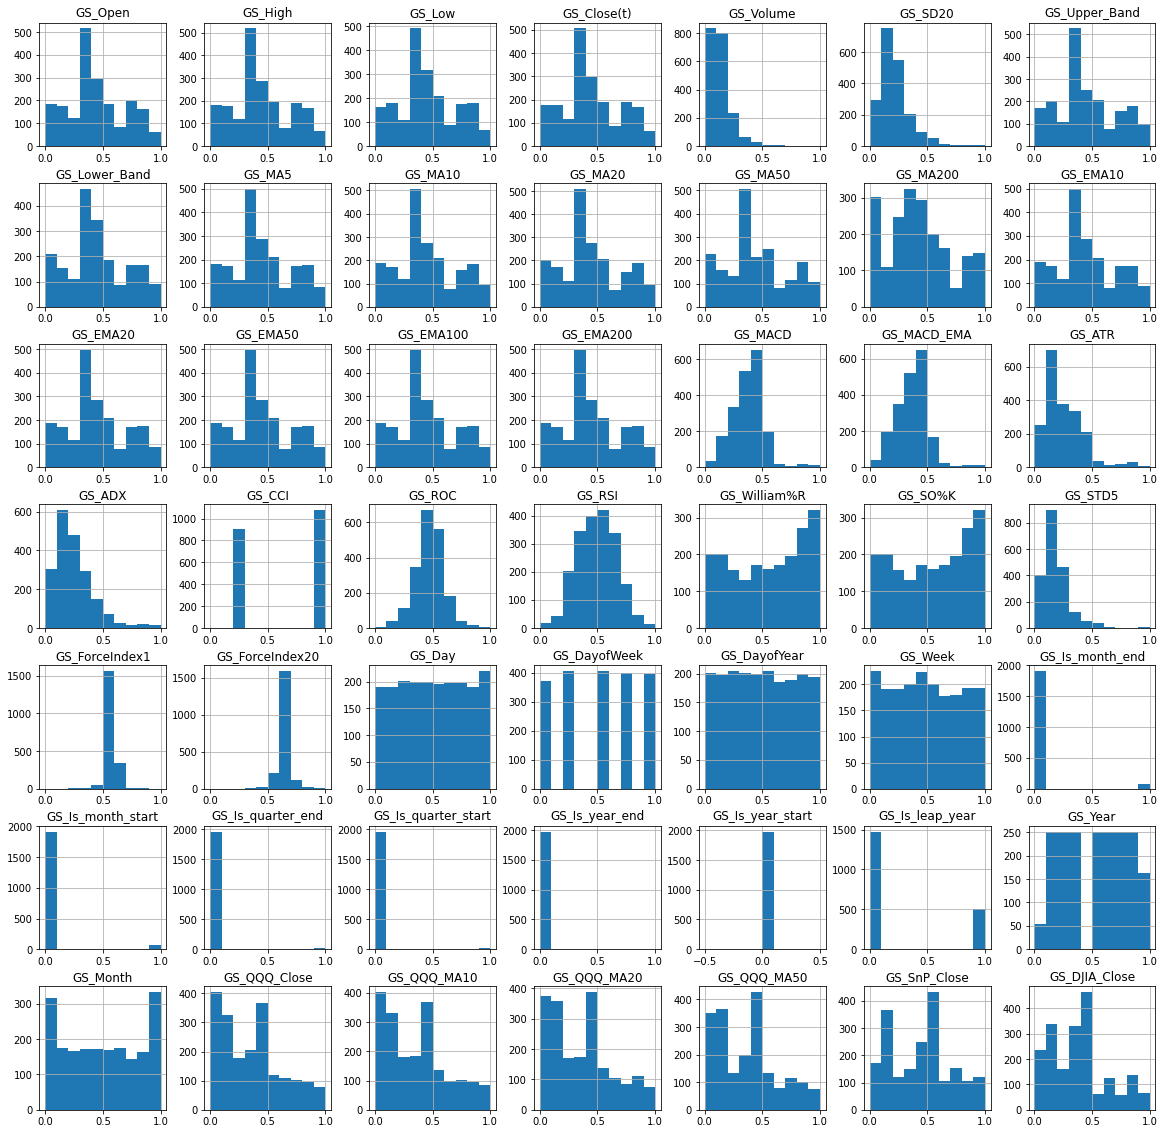

In [142]:
train_copy.filter(like="GS").hist(figsize=(20, 20));

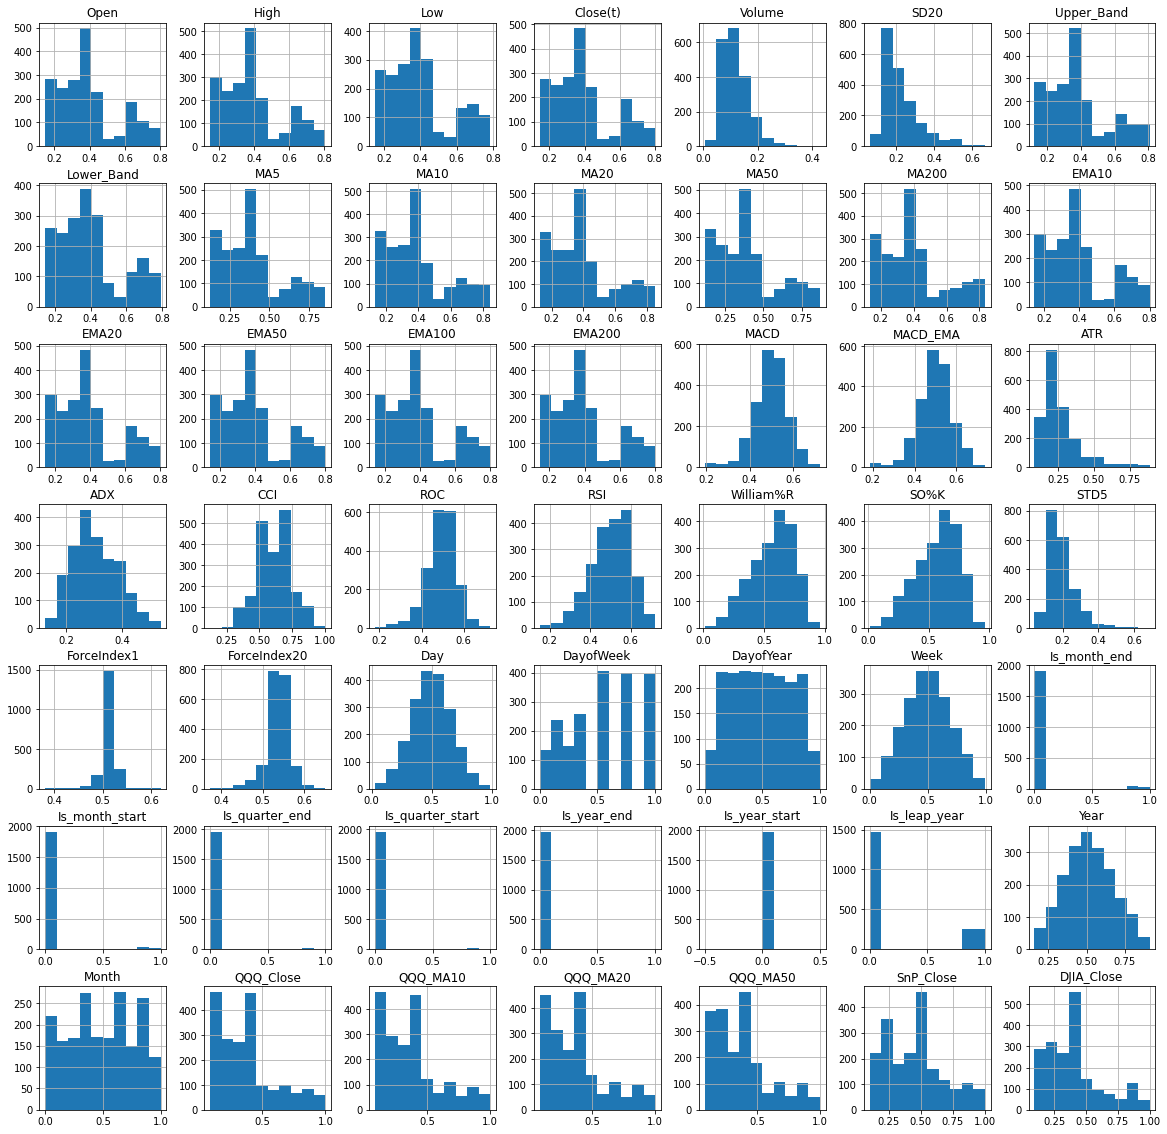

In [132]:
explore_data.hist(figsize=(20, 20));

<AxesSubplot:>

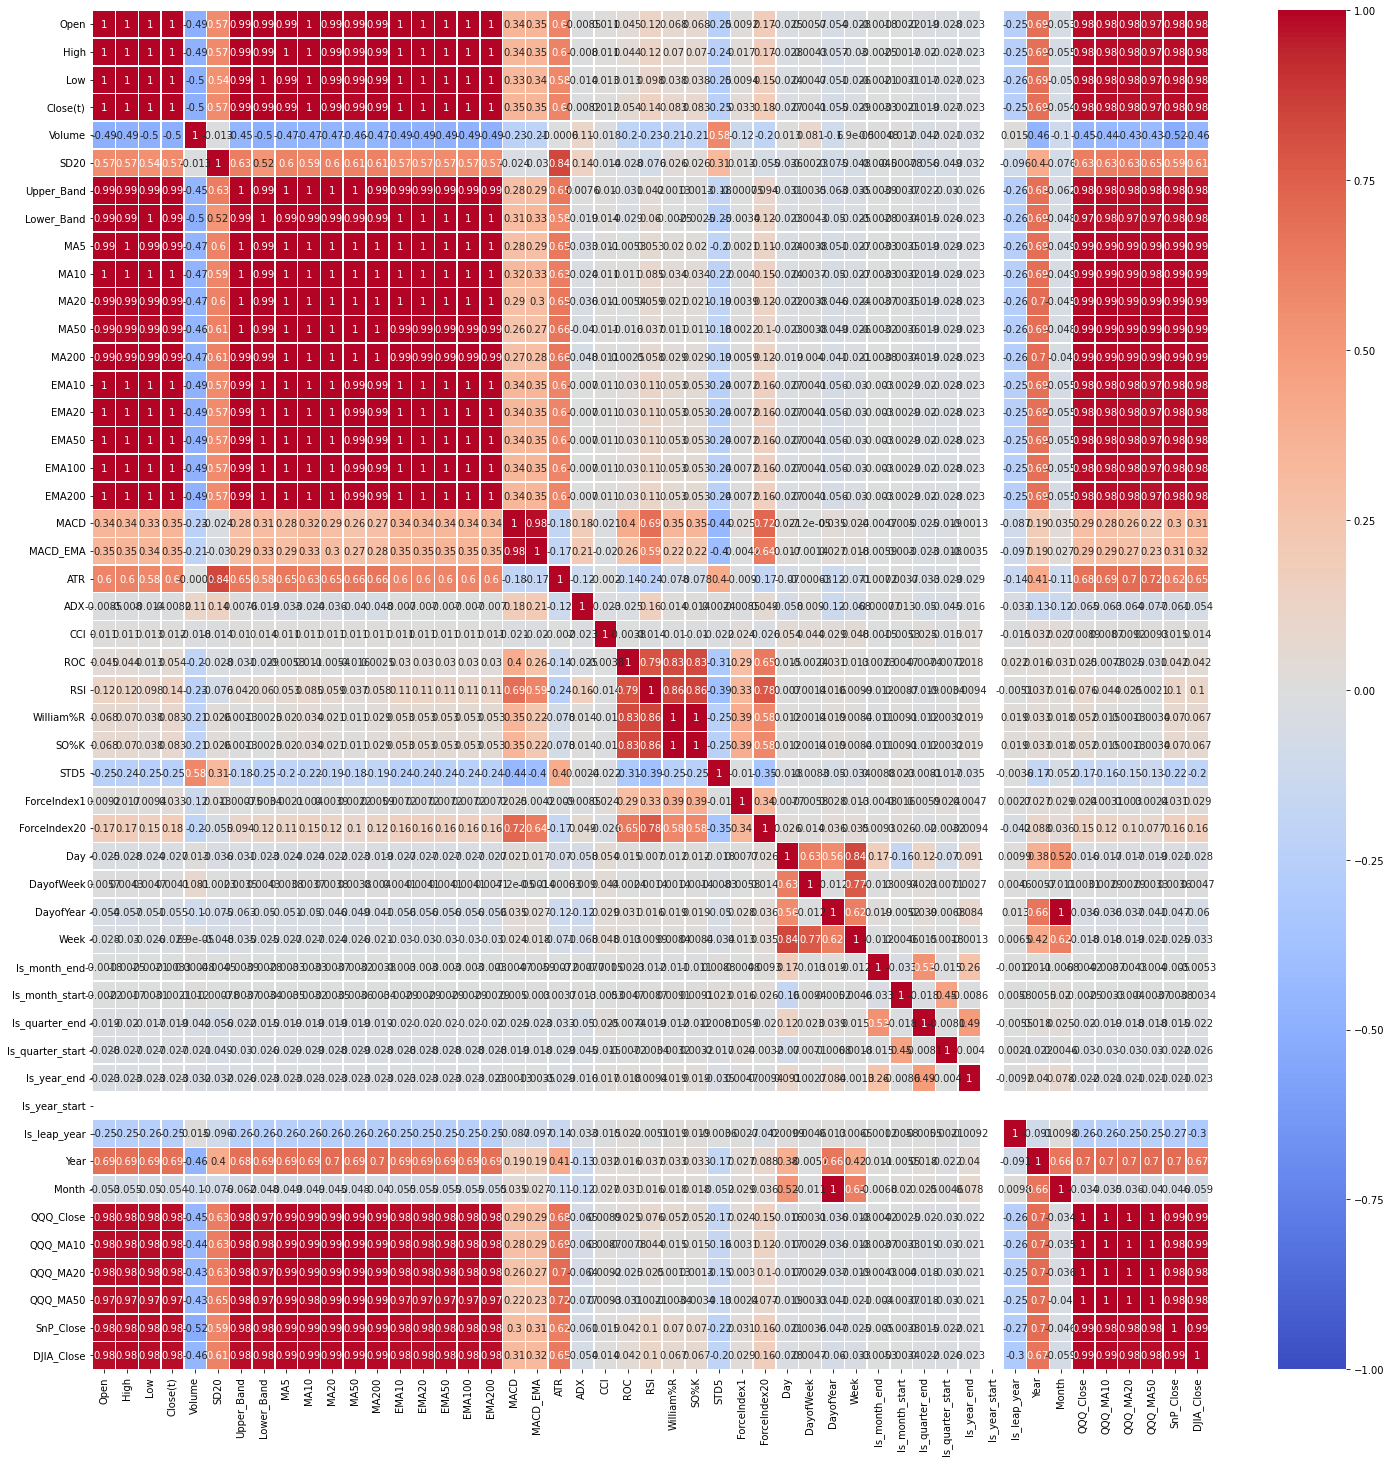

In [138]:
# sns heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(explore_data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', linewidths=0.5)